In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

In [2]:
filepath = 'data/new_portion_processed/zmean_train_80_with_teacher_scores.tsv'
df = pd.read_csv(filepath, sep='\t')

In [3]:
print(f"Dataset loaded: {len(df):,} samples")
print(f"Columns: {list(df.columns)}")
print(f"Data shape: {df.shape}")

Dataset loaded: 115,809 samples
Columns: ['index', 'src', 'mt', 'zmean', 'source_file', 'root_folder', 'file_type', 'global_index', 'teacher_score']
Data shape: (115809, 9)


In [4]:
print("Dataset Info:")
print("=" * 40)
print(df.info())
print("\nFirst 5 rows:")
print(df.head())

print("\nColumn data types:")
for col in df.columns:
    print(f"{col:25}: {df[col].dtype}")

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115809 entries, 0 to 115808
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   index          115809 non-null  int64  
 1   src            115809 non-null  object 
 2   mt             115809 non-null  object 
 3   zmean          115809 non-null  float64
 4   source_file    115809 non-null  object 
 5   root_folder    115809 non-null  object 
 6   file_type      115809 non-null  object 
 7   global_index   115809 non-null  int64  
 8   teacher_score  115809 non-null  float64
dtypes: float64(2), int64(2), object(5)
memory usage: 8.0+ MB
None

First 5 rows:
   index                                                src  \
0   6732  Many productions were musicals, comedies, melo...   
1  17034  Kerala Granthasala Sangham was founded in 1945...   
2   6141  These weekly calls always made her feel a litt...   
3    580  यो देखेर सोझा गोपहरूले देवता खुसी भएर

In [5]:
teacher_scores = df['teacher_score']
zmean_scores = df['zmean'] if 'zmean' in df.columns else None

print("COMET Teacher Score Analysis")
print("=" * 50)

print("\nBasic Statistics:")
print(f"Count: {len(teacher_scores):,}")
print(f"Mean: {teacher_scores.mean():.6f}")
print(f"Median: {teacher_scores.median():.6f}")
print(f"Mode: {teacher_scores.mode().iloc[0]:.6f}")
print(f"Standard Deviation: {teacher_scores.std():.6f}")
print(f"Variance: {teacher_scores.var():.6f}")
print(f"Range: [{teacher_scores.min():.6f}, {teacher_scores.max():.6f}]")
print(f"Range width: {teacher_scores.max() - teacher_scores.min():.6f}")


COMET Teacher Score Analysis

Basic Statistics:
Count: 115,809
Mean: 0.758307
Median: 0.798446
Mode: 0.604344
Standard Deviation: 0.125762
Variance: 0.015816
Range: [0.009851, 0.923483]
Range width: 0.913632


In [6]:
print("Distribution Properties:")
print("=" * 30)

skewness = stats.skew(teacher_scores)
kurtosis = stats.kurtosis(teacher_scores)

print(f"Skewness: {skewness:.4f}")
if skewness > 0.5:
    print("  -> Right-skewed (tail extends to the right)")
elif skewness < -0.5:
    print("  -> Left-skewed (tail extends to the left)")
else:
    print("  -> Approximately symmetric")

print(f"Kurtosis: {kurtosis:.4f}")
if kurtosis > 0:
    print("  -> Leptokurtic (heavy tails, sharp peak)")
elif kurtosis < 0:
    print("  -> Platykurtic (light tails, flat peak)")
else:
    print("  -> Mesokurtic (normal-like tails)")

Distribution Properties:
Skewness: -1.3185
  -> Left-skewed (tail extends to the left)
Kurtosis: 1.7988
  -> Leptokurtic (heavy tails, sharp peak)


In [7]:
print("Percentile Analysis:")
print("=" * 25)

percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99]
print("Percentile  Value")
print("-" * 20)
for p in percentiles:
    value = teacher_scores.quantile(p/100)
    print(f"{p:3d}th      {value:.6f}")

# Calculate IQR
Q1 = teacher_scores.quantile(0.25)
Q3 = teacher_scores.quantile(0.75)
IQR = Q3 - Q1
print(f"\nInterquartile Range (IQR): {IQR:.6f}")
print(f"Q1 (25th percentile): {Q1:.6f}")
print(f"Q3 (75th percentile): {Q3:.6f}")

Percentile Analysis:
Percentile  Value
--------------------
  1th      0.374282
  5th      0.508578
 10th      0.574245
 25th      0.691053
 50th      0.798446
 75th      0.853584
 90th      0.881221
 95th      0.891661
 99th      0.903553

Interquartile Range (IQR): 0.162531
Q1 (25th percentile): 0.691053
Q3 (75th percentile): 0.853584


In [8]:
def categorize_quality(score):
    if score < 0.2:
        return "Very Low"
    elif score < 0.4:
        return "Low"
    elif score < 0.6:
        return "Medium"
    elif score < 0.8:
        return "High"
    else:
        return "Very High"

df['quality_category'] = teacher_scores.apply(categorize_quality)
quality_dist = df['quality_category'].value_counts()

print("Quality Distribution:")
print("=" * 25)
print("Category     Count        Percentage")
print("-" * 40)
for quality in ["Very Low", "Low", "Medium", "High", "Very High"]:
    if quality in quality_dist.index:
        count = quality_dist[quality]
        percentage = (count / len(df)) * 100
        print(f"{quality:>10}: {count:>8,} ({percentage:6.2f}%)")
    else:
        print(f"{quality:>10}: {0:>8,} ({0:6.2f}%)")

Quality Distribution:
Category     Count        Percentage
----------------------------------------
  Very Low:      251 (  0.22%)
       Low:    1,328 (  1.15%)
    Medium:   13,094 ( 11.31%)
      High:   43,852 ( 37.87%)
 Very High:   57,284 ( 49.46%)


In [9]:
print("Outlier Analysis:")
print("=" * 20)

# IQR method
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_low = teacher_scores[teacher_scores < lower_bound]
outliers_high = teacher_scores[teacher_scores > upper_bound]
total_outliers = len(outliers_low) + len(outliers_high)

print(f"IQR Method:")
print(f"  Lower bound: {lower_bound:.6f}")
print(f"  Upper bound: {upper_bound:.6f}")
print(f"  Low outliers: {len(outliers_low):,} ({len(outliers_low)/len(teacher_scores)*100:.2f}%)")
print(f"  High outliers: {len(outliers_high):,} ({len(outliers_high)/len(teacher_scores)*100:.2f}%)")
print(f"  Total outliers: {total_outliers:,} ({total_outliers/len(teacher_scores)*100:.2f}%)")

# Z-score method (3 sigma rule)
z_scores = np.abs(stats.zscore(teacher_scores))
outliers_zscore = teacher_scores[z_scores > 3]
print(f"\nZ-score Method (|z| > 3):")
print(f"  Outliers: {len(outliers_zscore):,} ({len(outliers_zscore)/len(teacher_scores)*100:.2f}%)")


Outlier Analysis:
IQR Method:
  Lower bound: 0.447256
  Upper bound: 1.097381
  Low outliers: 2,818 (2.43%)
  High outliers: 0 (0.00%)
  Total outliers: 2,818 (2.43%)

Z-score Method (|z| > 3):
  Outliers: 1,255 (1.08%)


In [10]:
print("Data Quality Analysis:")
print("=" * 25)

print(f"Missing values: {teacher_scores.isnull().sum():,}")
print(f"Duplicate values: {teacher_scores.duplicated().sum():,}")
print(f"Unique values: {teacher_scores.nunique():,}")
print(f"Value repetition ratio: {teacher_scores.nunique() / len(teacher_scores):.4f}")

# Most common values
print(f"\nMost frequent scores:")
top_values = teacher_scores.value_counts().head(10)
for i, (score, count) in enumerate(top_values.items(), 1):
    print(f"  {i:2d}. {score:.6f}: {count:,} occurrences")

# Check for suspicious patterns
print(f"\nSuspicious patterns:")
rounded_scores = teacher_scores.round(2)
if rounded_scores.nunique() < teacher_scores.nunique() * 0.1:
    print("  Warning: Many scores appear to be rounded")
else:
    print("  No obvious rounding detected")

Data Quality Analysis:
Missing values: 0
Duplicate values: 11,518
Unique values: 104,291
Value repetition ratio: 0.9005

Most frequent scores:
   1. 0.740173: 4 occurrences
   2. 0.675157: 4 occurrences
   3. 0.678412: 4 occurrences
   4. 0.798996: 4 occurrences
   5. 0.709318: 4 occurrences
   6. 0.876477: 4 occurrences
   7. 0.901695: 4 occurrences
   8. 0.869505: 4 occurrences
   9. 0.867186: 4 occurrences
  10. 0.878164: 4 occurrences

Suspicious patterns:


In [13]:
if zmean_scores is not None:
    print("Correlation with Original Zmean:")
    print("=" * 35)
    
    # Pearson correlation
    pearson_corr = teacher_scores.corr(zmean_scores)
    print(f"Pearson correlation: {pearson_corr:.6f}")
    
    # Spearman correlation (rank-based)
    spearman_corr = stats.spearmanr(teacher_scores, zmean_scores)[0]
    print(f"Spearman correlation: {spearman_corr:.6f}")
    
    # Kendall's tau
    kendall_corr = stats.kendalltau(teacher_scores, zmean_scores)[0]
    print(f"Kendall's tau: {kendall_corr:.6f}")
    
    print(f"\nZmean score range: [{zmean_scores.min():.6f}, {zmean_scores.max():.6f}]")
    print(f"Teacher score range: [{teacher_scores.min():.6f}, {teacher_scores.max():.6f}]")
    
    # Agreement analysis
    teacher_median = teacher_scores.median()
    zmean_median = zmean_scores.median()
    
    high_teacher = teacher_scores > teacher_median
    high_zmean = zmean_scores > zmean_median
    agreement = (high_teacher == high_zmean).mean()
    print(f"Binary agreement (above/below median): {agreement:.4f}")
    
else:
    print("No zmean column found for correlation analysis")


Correlation with Original Zmean:
Pearson correlation: 0.595317
Spearman correlation: 0.561425
Kendall's tau: 0.399508

Zmean score range: [-7.541931, 8.454313]
Teacher score range: [0.009851, 0.923483]
Binary agreement (above/below median): 0.7016


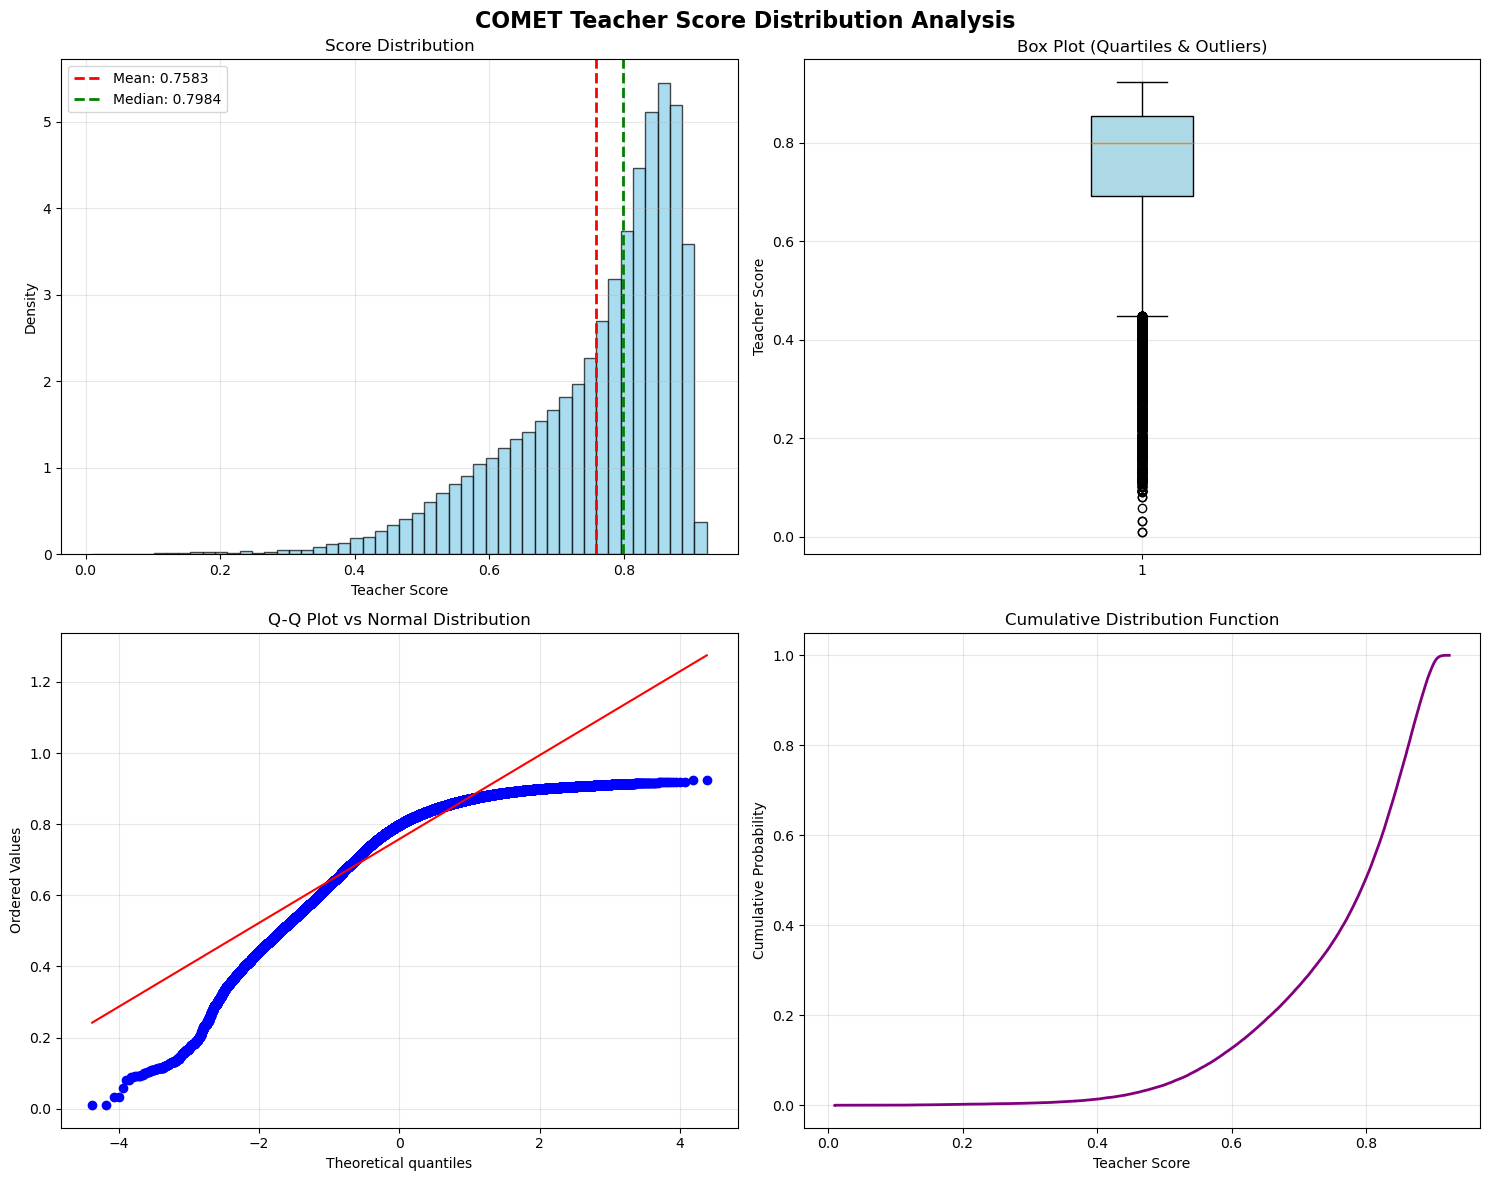

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('COMET Teacher Score Distribution Analysis', fontsize=16, fontweight='bold')

# Histogram
axes[0,0].hist(teacher_scores, bins=50, alpha=0.7, color='skyblue', edgecolor='black', density=True)
axes[0,0].axvline(teacher_scores.mean(), color='red', linestyle='--', linewidth=2, 
                  label=f'Mean: {teacher_scores.mean():.4f}')
axes[0,0].axvline(teacher_scores.median(), color='green', linestyle='--', linewidth=2,
                  label=f'Median: {teacher_scores.median():.4f}')
axes[0,0].set_xlabel('Teacher Score')
axes[0,0].set_ylabel('Density')
axes[0,0].set_title('Score Distribution')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Box plot
box_plot = axes[0,1].boxplot(teacher_scores, vert=True, patch_artist=True)
box_plot['boxes'][0].set_facecolor('lightblue')
axes[0,1].set_ylabel('Teacher Score')
axes[0,1].set_title('Box Plot (Quartiles & Outliers)')
axes[0,1].grid(True, alpha=0.3)

# Q-Q plot against normal distribution
from scipy.stats import probplot
probplot(teacher_scores, dist="norm", plot=axes[1,0])
axes[1,0].set_title('Q-Q Plot vs Normal Distribution')
axes[1,0].grid(True, alpha=0.3)

# Cumulative distribution
sorted_scores = np.sort(teacher_scores)
y = np.arange(1, len(sorted_scores) + 1) / len(sorted_scores)
axes[1,1].plot(sorted_scores, y, linewidth=2, color='purple')
axes[1,1].set_xlabel('Teacher Score')
axes[1,1].set_ylabel('Cumulative Probability')
axes[1,1].set_title('Cumulative Distribution Function')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [15]:
summary_stats = {
    'Statistic': ['Count', 'Mean', 'Median', 'Std Dev', 'Min', 'Max', 
                  'Range', '25th %ile', '75th %ile', 'IQR', 'Skewness', 'Kurtosis'],
    'Value': [
        f"{len(teacher_scores):,}",
        f"{teacher_scores.mean():.6f}",
        f"{teacher_scores.median():.6f}",
        f"{teacher_scores.std():.6f}",
        f"{teacher_scores.min():.6f}",
        f"{teacher_scores.max():.6f}",
        f"{teacher_scores.max() - teacher_scores.min():.6f}",
        f"{Q1:.6f}",
        f"{Q3:.6f}",
        f"{IQR:.6f}",
        f"{skewness:.6f}",
        f"{kurtosis:.6f}"
    ]
}

summary_df = pd.DataFrame(summary_stats)
print("Summary Statistics Table:")
print("=" * 30)
print(summary_df.to_string(index=False))

Summary Statistics Table:
Statistic     Value
    Count   115,809
     Mean  0.758307
   Median  0.798446
  Std Dev  0.125762
      Min  0.009851
      Max  0.923483
    Range  0.913632
25th %ile  0.691053
75th %ile  0.853584
      IQR  0.162531
 Skewness -1.318502
 Kurtosis  1.798768
